## <u> Client Segmentation </u>

This notebook develops customer segmentation based on default risk using the predicted probabilities from the LightGBM model built in `01_modelling.ipynb`. The analysis segments customers into risk tiers and profiles the characteristics that define each group, providing actionable insights for credit evaluation, pricing strategy, and portfolio management at Home Credit.

### <u> 1. Setup</u>

In [1]:
# Import necessary libraries
import pandas as pd, sys
import matplotlib.pyplot as plt
import numpy as np


# Set root directory for personal module
sys.path.append('..')

In [2]:
# Import dataframe along with model predictions
home_credit = pd.read_csv('../data/processed/home_credit_final.csv', index_col=0)
model_preds = pd.read_csv('../data/processed/model_predictions.csv', index_col=0)


# Merge feature with model prediction
home_credit_ext = home_credit.merge(right = model_preds, right_index = True, left_index = True, how = 'left')
home_credit_ext.head(5)


,EXT_SOURCE_3,EXT_SOURCE_1,EXT_SOURCE_2,YEARS_EMPLOYED,YEARS_BIRTH,OCCUPATION_TYPE,ORGANIZATION_TYPE,NAME_INCOME_TYPE,REG_CITY_NOT_WORK_CITY,YEARS_LAST_PHONE_CHANGE,...,AMT_ANNUITY,prev_cnt_revolving_refused,prev_has_history,prev_cnt_revolving_canceled,prev_cnt_cash_refused,TARGET,actual,predicted_probability,predicted_class,split
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
149977,0.567379,NaN,0.318931,13.8,47.1,Laborers,Industry: type 7,Working,0,5.3,...,37800.0,0,1,0,0,0,0,0.047600,0,train
149261,0.197475,0.37669,0.121854,1.2,35.7,Private service staff,Self-employed,Working,1,0.2,...,27652.5,0,1,0,1,1,1,0.314944,1,train
451117,NaN,NaN,0.162192,24.2,42.3,Laborers,Industry: type 11,Working,0,2.4,...,11101.5,0,1,0,0,0,0,0.089163,1,train
452063,0.248536,NaN,0.548223,2.7,37.2,Sales staff,Trade: type 7,Working,0,1.7,...,24232.5,0,1,2,2,0,0,0.103559,1,train
246378,0.401407,NaN,0.565295,1.6,48.9,Not Provided,Business Entity Type 3,Working,0,6.2,...,37017.0,4,1,2,2,0,0,0.188026,1,train


### <u> 2. Segmentation</u>

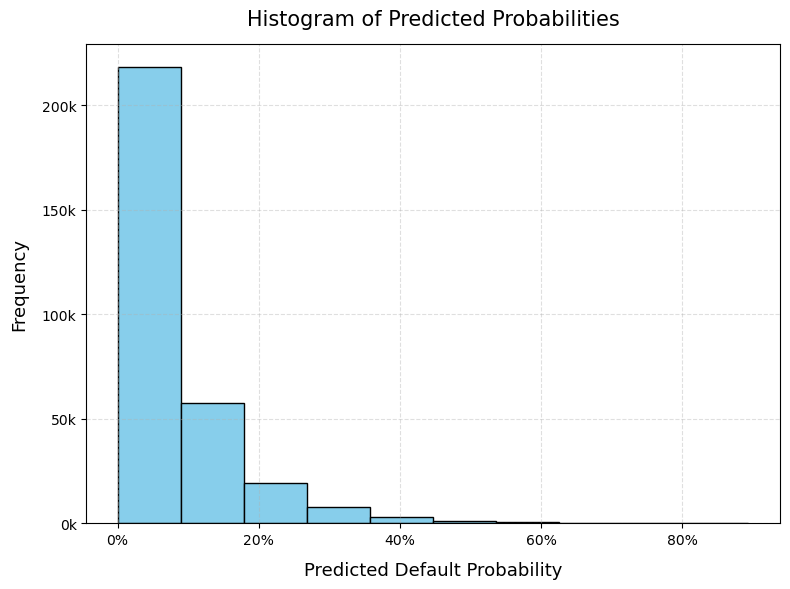

In [3]:
home_credit_ext['predicted_probability'].hist(bins=10, figsize=(8,6), color='skyblue', edgecolor='black')
plt.title('Histogram of Predicted Probabilities', fontsize=15, pad= 14)
plt.xlabel('Predicted Default Probability', fontsize=13, labelpad=10)
plt.ylabel('Frequency', fontsize=13, labelpad= 10)
ax = plt.gca()
ax.yaxis.set_major_formatter(lambda x, pos: f'{int(x/1000)}k')
ax.xaxis.set_major_formatter(lambda x, pos: f'{x*100:.0f}%')
plt.grid(linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [4]:
# Define risk bins based on predicted probabilities of default
bins = [0, 0.05, 0.10, 0.2, 1.0]
labels = ['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk']

# Segment customers into risk categories
home_credit_ext['risk_segment'] = pd.cut(home_credit_ext['predicted_probability'], bins=bins, labels=labels, include_lowest=True)
home_credit_ext[['predicted_probability', 'risk_segment']].head(3)

,predicted_probability,risk_segment
SK_ID_CURR,,
149977,0.047600,Very Low Risk
149261,0.314944,High Risk
451117,0.089163,Low Risk


In [ ]:
# Save extended dataframe with risk segments for future analysis in Python / Power BI
# home_credit_ext.to_csv('../data/processed/home_credit_with_segments.csv')
# home_credit_ext.to_excel('../data/processed/home_credit_with_segments.xlsx')

In [6]:
# Import DataFrame and set risk segment order
home_credit_ext = pd.read_csv('../data/processed/home_credit_with_segments.csv', index_col=0)
risk_order = ['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk']
home_credit_ext['risk_segment'] = pd.Categorical(
    home_credit_ext['risk_segment'],
    categories=risk_order,
    ordered=True
)


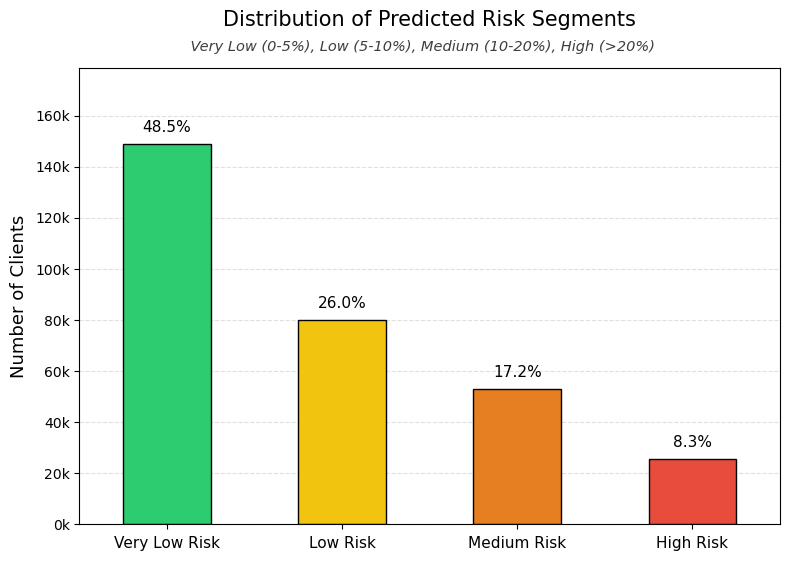

In [7]:
# Risk palette
risk_colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']

# Risk order
risk_order = ['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk']

home_credit_ext['risk_segment'].value_counts().plot(kind='bar', figsize=(8,6), color=risk_colors, edgecolor='black', zorder=2)
plt.title('Distribution of Predicted Risk Segments', fontsize=15, pad=30)
plt.suptitle('            Very Low (0-5%), Low (5-10%), Medium (10-20%), High (>20%)', 
             fontsize=10.5, y=0.877, style='italic', ha='center', color= "#3E3E3E")

plt.ylabel('Number of Clients', fontsize=13, labelpad= 5)
plt.xlabel('', labelpad= 5)
ax = plt.gca()
ax.yaxis.set_major_formatter(lambda x, pos: f'{int(x/1000)}k')
plt.ylim(0, home_credit_ext['risk_segment'].value_counts().max() * 1.2)
ax.tick_params(axis='x', rotation=0, labelsize=11, pad=5)

# Inlcude percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/len(home_credit_ext)*100:.1f}%', 
                (p.get_x() + p.get_width() / 2, height+ 3500), 
                ha='center', va='bottom', fontsize=11, )

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('../images/risk_segment_distribution.png', dpi=600, bbox_inches='tight')
plt.show()

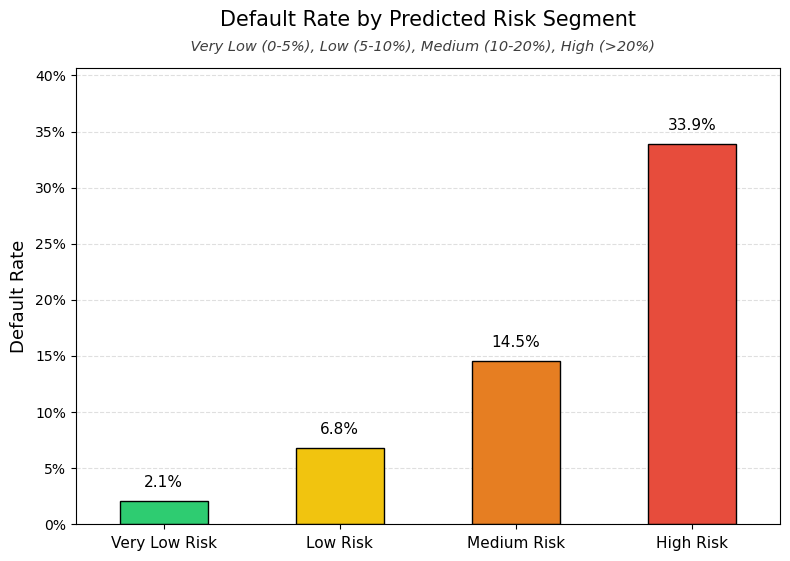

In [8]:
# Percentage default rate by risk segment
default_rates = home_credit_ext.groupby('risk_segment', observed=True)['TARGET'].mean() * 100

# Risk palette
risk_colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']

default_rates.plot(kind='bar', figsize=(8,6), color=risk_colors, edgecolor='black', zorder=2)
plt.title('Default Rate by Predicted Risk Segment', fontsize=15, pad=30)
plt.suptitle('            Very Low (0-5%), Low (5-10%), Medium (10-20%), High (>20%)', 
             fontsize=10.5, y=0.877, style='italic', ha='center', color= "#3E3E3E")

plt.ylabel('Default Rate', fontsize=13, labelpad= 5)
plt.xlabel('', labelpad= 5)
ax = plt.gca()
ax.yaxis.set_major_formatter(lambda x, pos: f'{int(x)}%')
plt.ylim(0, default_rates.max() * 1.2)
ax.tick_params(axis='x', rotation=0, labelsize=11, pad=5)


# Inlcude percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', 
                (p.get_x() + p.get_width() / 2, height+ 1), 
                ha='center', va='bottom', fontsize=11, )

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('../images/default_rate_by_risk_segment.png', dpi=600, bbox_inches='tight')
plt.show()

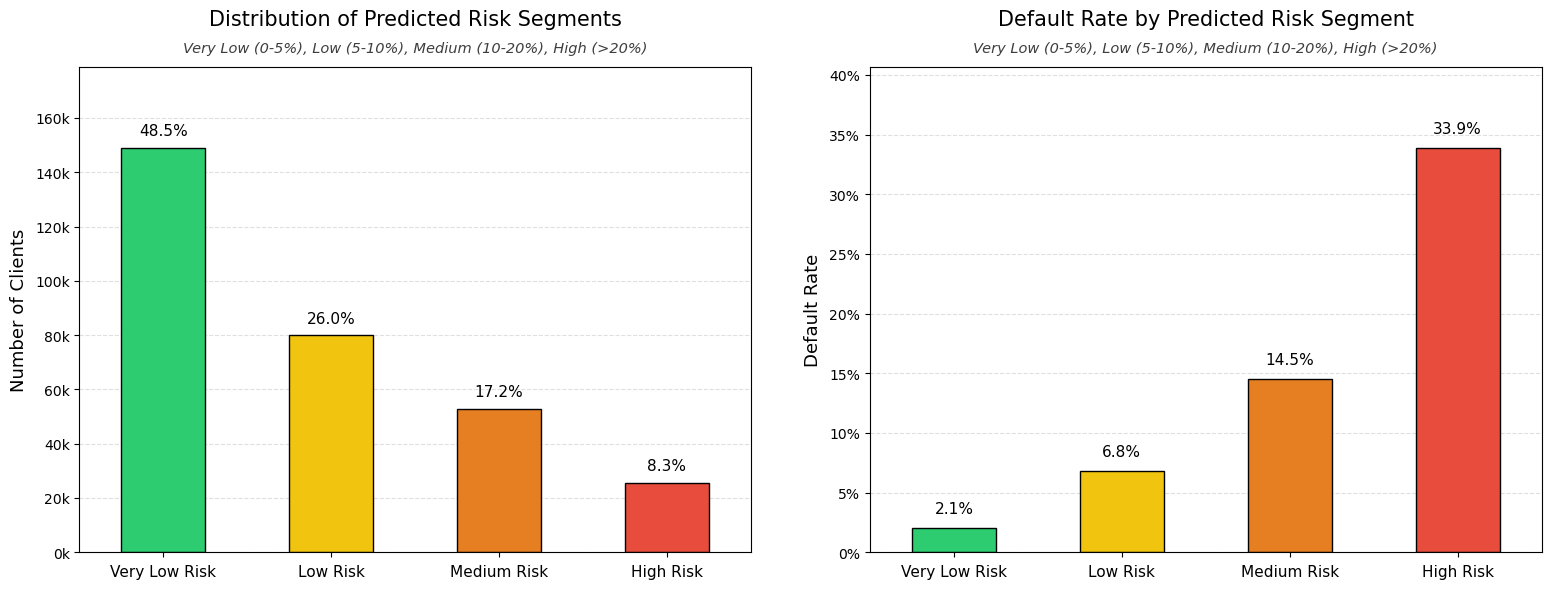

In [9]:
# Risk palette and order
risk_colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']
risk_order = ['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk']

# Create 1x2 figure of previous plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LEFT PLOT: Distribution of Risk Segments
home_credit_ext['risk_segment'].value_counts().plot(
    kind='bar', ax=axes[0], color=risk_colors, edgecolor='black', zorder=2
)
axes[0].set_title('Distribution of Predicted Risk Segments', fontsize=15, pad=30)
axes[0].text(0.5, 1.03, 'Very Low (0-5%), Low (5-10%), Medium (10-20%), High (>20%)',
             transform=axes[0].transAxes, fontsize=10.5, style='italic', 
             ha='center', color='#3E3E3E')
axes[0].set_ylabel('Number of Clients', fontsize=13, labelpad=5)
axes[0].set_xlabel('', labelpad=5)
axes[0].yaxis.set_major_formatter(lambda x, pos: f'{int(x/1000)}k')
axes[0].set_ylim(0, home_credit_ext['risk_segment'].value_counts().max() * 1.2)
axes[0].tick_params(axis='x', rotation=0, labelsize=11, pad=5)

# Add percentage labels
for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f'{height/len(home_credit_ext)*100:.1f}%', 
                     (p.get_x() + p.get_width() / 2, height + 3500), 
                     ha='center', va='bottom', fontsize=11)

axes[0].grid(axis='y', linestyle='--', alpha=0.4)


# RIGHT PLOT: Default Rate by Risk Segment
default_rates = home_credit_ext.groupby('risk_segment', observed=True)['TARGET'].mean() * 100

default_rates.plot(kind='bar', ax=axes[1], color=risk_colors, edgecolor='black', zorder=2)
axes[1].set_title('Default Rate by Predicted Risk Segment', fontsize=15, pad=30)
axes[1].text(0.5, 1.03, 'Very Low (0-5%), Low (5-10%), Medium (10-20%), High (>20%)',
             transform=axes[1].transAxes, fontsize=10.5, style='italic',
             ha='center', color='#3E3E3E')
axes[1].set_ylabel('Default Rate', fontsize=13, labelpad=5)
axes[1].set_xlabel('', labelpad=5)
axes[1].yaxis.set_major_formatter(lambda x, pos: f'{int(x)}%')
axes[1].set_ylim(0, default_rates.max() * 1.2)
axes[1].tick_params(axis='x', rotation=0, labelsize=11, pad=5)

# Add percentage labels
for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f'{height:.1f}%', 
                     (p.get_x() + p.get_width() / 2, height + 1), 
                     ha='center', va='bottom', fontsize=11)

axes[1].grid(axis='y', linestyle='--', alpha=0.4)

plt.subplots_adjust(wspace=1.2)
plt.tight_layout()
plt.savefig('../images/risk_segment_overview.png', dpi=600, bbox_inches='tight')
plt.show()

<u> **Comment:** </u>

The distribution and observed default rates across risk segments confirm the model's ability to separate risk effectively and provide a clear foundation for differentiated lending strategies. The Very Low Risk segment comprises nearly half the customer base (49.1%) with a minimal 2.0% default rate, suggesting these applications can be processed through automated approval workflows to improve efficiency. The Low Risk segment (25.6%) shows a moderate 6.8% default rate, warranting standard screening procedures with selective manual review. The Medium Risk segment (16.9%) exhibits a more concerning 14.6% default rate, requiring deeper assessment of individual applications to identify borrowers likely to repay despite the elevated risk profile. The High Risk segment, while representing only 8.4% of customers, demonstrates a substantial 34.4% default rate that raises questions about whether any feasible pricing structure can adequately compensate for this level of risk, or whether these applications should be declined outright when they exceed acceptable thresholds. The segmentation framework enables Home Credit to concentrate resources on cases where detailed underwriting adds the most value in preventing losses, while streamlining processes for the majority of lower-risk applications.


### <u> 2. Segment Profile</u>

In [10]:
# Columns to profile
profile_columns = [
    'CODE_GENDER', 'YEARS_BIRTH', 'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS',
    'YEARS_EMPLOYED', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'OWN_CAR_AGE', 'AMT_CREDIT',
    'bur_cnt_active', 'prev_cnt_consumer_approved', 'prev_cnt_cash_refused'
]

profile_df = home_credit_ext[profile_columns]

# Split qualitative and quantitative columns
num_cols = profile_df.select_dtypes(include='number').columns
cat_cols = profile_df.select_dtypes(exclude='number').columns


# Numerical profile with means
num_profile = (home_credit_ext.groupby('risk_segment', observed=True)[num_cols]
               .mean().round(2)
                
)

# Add overall population
overall_num = home_credit_ext[num_cols].mean().round(2).to_frame().T
overall_num.index = ['Overall Population']
num_profile = pd.concat([overall_num, num_profile])
num_profile['AMT_CREDIT'] = num_profile['AMT_CREDIT'].apply(lambda x: f"${x:,.0f}")


# Categorical profile with mode and percentage
def mode_with_percentage(series):
    mode_val = series.mode().iloc[0]
    percentage = (series == mode_val).sum() / len(series) * 100
    return f"{mode_val} ({percentage:.1f}%)"

cat_profile = (home_credit_ext.groupby('risk_segment', observed=True)[cat_cols]
               .agg(mode_with_percentage)
                 
)

# Add overall population for categorical
overall_cat = home_credit_ext[cat_cols].agg(mode_with_percentage).to_frame().T
overall_cat.index = ['Overall Population']
cat_profile = pd.concat([overall_cat, cat_profile])

In [11]:
# Display both tables
print("=" * 32)
print("NUMERICAL PROFILE (Mean Values)")
print("=" * 32)
display(num_profile)

print("\n" + "=" * 43)
print("CATEGORICAL PROFILE (Mode with Percentage)")
print("=" * 43)
display(cat_profile)

NUMERICAL PROFILE (Mean Values)


,YEARS_BIRTH,YEARS_EMPLOYED,OWN_CAR_AGE,AMT_CREDIT,bur_cnt_active,prev_cnt_consumer_approved,prev_cnt_cash_refused
Overall Population,43.94,6.53,12.06,"$599,026",1.76,1.75,0.45
Very Low Risk,47.07,8.36,10.52,"$638,882",1.59,1.86,0.27
Low Risk,43.10,5.70,13.02,"$586,975",1.77,1.72,0.48
Medium Risk,39.62,4.70,14.31,"$546,795",1.94,1.62,0.66
High Risk,37.23,3.85,15.24,"$512,304",2.35,1.45,1.02



CATEGORICAL PROFILE (Mode with Percentage)


,CODE_GENDER,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,ORGANIZATION_TYPE,OCCUPATION_TYPE
Overall Population,F (65.8%),Secondary (71.0%),Married (63.9%),Business Entity Type 3 (22.1%),Not Provided (31.3%)
Very Low Risk,F (73.9%),Secondary (62.9%),Married (67.0%),XNA (23.8%),Not Provided (37.0%)
Low Risk,F (63.6%),Secondary (75.5%),Married (62.9%),Business Entity Type 3 (22.8%),Not Provided (30.3%)
Medium Risk,F (55.2%),Secondary (80.4%),Married (60.5%),Business Entity Type 3 (26.8%),Laborers (24.7%)
High Risk,M (52.0%),Secondary (84.7%),Married (56.0%),Business Entity Type 3 (29.3%),Laborers (30.2%)


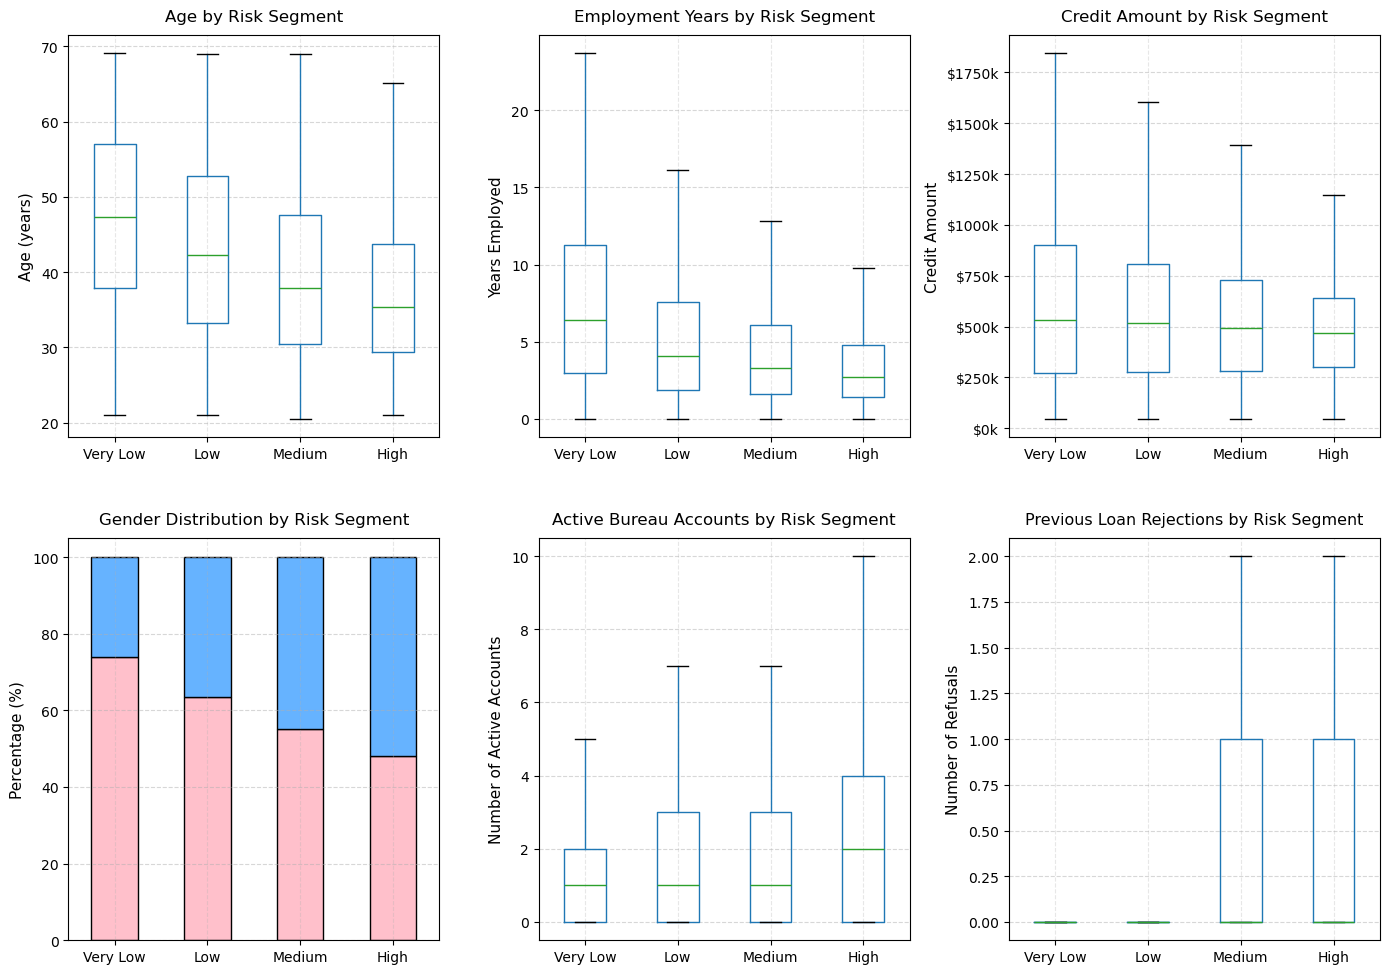

In [12]:
# Convert risk_segment to ordered categorical BEFORE plotting
home_credit_ext['risk_segment'] = pd.Categorical(
    home_credit_ext['risk_segment'],
    categories=risk_order,
    ordered=True
)

fig, axes = plt.subplots(2, 3, figsize=(14, 10))

# Abbreviation risk segments
risk_labels = ['Very Low', 'Low', 'Medium', 'High']

# Top row
# Age distribution
home_credit_ext.boxplot(column='YEARS_BIRTH', by='risk_segment', ax=axes[0, 0], showfliers=False)
axes[0, 0].set_title('Age by Risk Segment', fontsize=12, pad=10)
axes[0, 0].set_xlabel('',labelpad=10)
axes[0, 0].set_ylabel('Age (years)', fontsize=11, labelpad=5)
axes[0, 0].set_xticklabels(risk_labels, rotation=0, ha='center')

# Employment years
home_credit_ext.boxplot(column='YEARS_EMPLOYED', by='risk_segment', ax=axes[0, 1], showfliers=False)
axes[0, 1].set_title('Employment Years by Risk Segment', fontsize=12, pad=10)
axes[0, 1].set_xlabel('', labelpad=10)
axes[0, 1].set_ylabel('Years Employed', fontsize=11, labelpad=5)
axes[0, 1].set_xticklabels(risk_labels, rotation=0, ha='center')

# Credit amount
home_credit_ext.boxplot(column='AMT_CREDIT', by='risk_segment', ax=axes[0, 2], showfliers=False)
axes[0, 2].set_title('Credit Amount by Risk Segment', fontsize=12, pad=10)
axes[0, 2].set_xlabel('', labelpad=10)
axes[0, 2].set_ylabel('Credit Amount', fontsize=11, labelpad=5)
axes[0, 2].yaxis.set_major_formatter(lambda x, pos: f'${int(x/1000)}k')
axes[0, 2].set_xticklabels(risk_labels, rotation=0, ha='center')

# Bottom row
# Gender distribution (stacked bar)
gender_pivot = pd.crosstab(home_credit_ext['risk_segment'], 
                           home_credit_ext['CODE_GENDER'], 
                           normalize='index') * 100
gender_pivot.plot(kind='bar', stacked=True, ax=axes[1, 0], 
                  color=['pink', '#66b3ff'], edgecolor='black', legend=False)
axes[1, 0].set_title('Gender Distribution by Risk Segment', fontsize=12, pad=10)
axes[1, 0].set_ylabel('Percentage (%)', fontsize=11, labelpad=5)
axes[1, 0].set_xlabel('')
axes[1, 0].set_xticklabels(risk_labels, rotation=0, ha='center')

# Bureau active accounts
home_credit_ext.boxplot(column='bur_cnt_active', by='risk_segment', ax=axes[1, 1], showfliers=False)
axes[1, 1].set_title('Active Bureau Accounts by Risk Segment', fontsize=12, pad=10)
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('Number of Active Accounts', fontsize=11, labelpad=5)
axes[1, 1].set_xticklabels(risk_labels, rotation=0, ha='center')

# Previous loan cash application refused
home_credit_ext.boxplot(column='prev_cnt_cash_refused', by='risk_segment', ax=axes[1, 2], showfliers=False)
axes[1, 2].set_title('Previous Loan Rejections by Risk Segment', fontsize=11.5, pad=10)
axes[1, 2].set_xlabel('')
axes[1, 2].set_ylabel('Number of Refusals', fontsize=11, labelpad=5)
axes[1, 2].set_xticklabels(risk_labels, rotation=0, ha='center')

# Apply grid over all axis
for ax in axes.flat:
    ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=1)
    ax.grid(axis='x', linestyle='--', alpha=0.3)

# Remove suptitle
fig.suptitle('') 
plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
plt.savefig('../images/risk_segment_feature_comparison.png', dpi=600, bbox_inches='tight')
plt.show()

<u>**Comment:**</u>

From the feature comparison across risk segments we can observe coherent patterns that validate the model's segmentation logic and align with established credit risk principles. The most pronounced relationships emerge in demographic and employment stability indicators, where age and employment tenure demonstrate clear negative associations with default risk. Higher-risk customers are systematically younger and hold shorter employment histories, suggesting that financial stability accumulates with professional maturity and workplace continuity. This pattern supports the fundamental credit hypothesis that stable income streams enable consistent loan repayment.

An unexpected inverse relationship appears instead in the credit amount requested, where higher loan values correlate with lower default rates. This counterintuitive pattern likely reflects selection bias in the approval process rather than a causal relationship. Home Credit presumably applies stricter screening criteria for large loan amounts, effectively filtering out high-risk applicants at the underwriting stage. The observed data therefore captures only those high-value borrowers who passed enhanced scrutiny, creating an artifact where approved large loans appear safer than they would be without this filtering effect. Gender composition shifts notably across risk tiers, with female representation declining from 73.9% in the Very Low Risk segment to near parity in the High Risk segment. While this pattern does not justify differential treatment by gender, it likely reflects unmeasured socioeconomic factors that correlate with both gender and creditworthiness in the dataset's geographic and cultural context. Variables such as occupational segregation, household financial responsibilities, or risk-taking behaviors may create these observed differences without being directly captured in the available features.

 Lastly, credit history variables perform as expected, with previous loan refusals and multiple active bureau accounts serving as clear risk indicators. Customers with prior rejections who subsequently gained approval demonstrate elevated default rates, suggesting that their improved circumstances or alternative lenders may not have fully mitigated underlying risk factors. Similarly, borrowers handling multiple concurrent loans face higher repayment burdens, increasing their probability of default. Occupational categories reveal modest differentiation, with Business Entity Type 3 organizations and Laborers showing slightly elevated representation in higher-risk segments, though these effects are less pronounced than the demographic and credit history patterns.


In conclusion these findings confirm that the model captures economically meaningful risk distinctions rather than artificial correlations. The segmentation framework reflects established credit risk drivers such as stability, capacity, and credit history, providing confidence that the derived risk tiers can support differentiated lending strategies.